In [29]:
# import packages
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from bt_classes import my_backtest
# orig_df = pd.read_csv('../res/test_data.csv',index_col=0,parse_dates=True)
# my_backtest(orig_df[:500])
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 20,10
# df = pd.read_csv('../res/input0130.csv')

orig_df = pd.read_csv('../xau_1d_20y.csv')
orig_df['datetime'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.set_index('datetime')

df = orig_df.copy()
df['log_r'] = np.log(df['close']) - np.log(df['open'])
df['label'] = np.sign(df['log_r'].shift(-1))
df['label'][df['label']==-1] = 0
df['label'].fillna(0,inplace=True)

In [8]:
y_true = np.random.randint(0,2,10000)
y_pred = np.random.randint(0,2,10000)

In [32]:
ti = test_indicator(y_true,y_pred)

In [36]:
ti.suc_fail[:,5:].sum() / ti.suc_fail.sum()

0.0657258064516129

In [26]:
suc_fail, fail_suc = np.array(ti.successive_distribution())

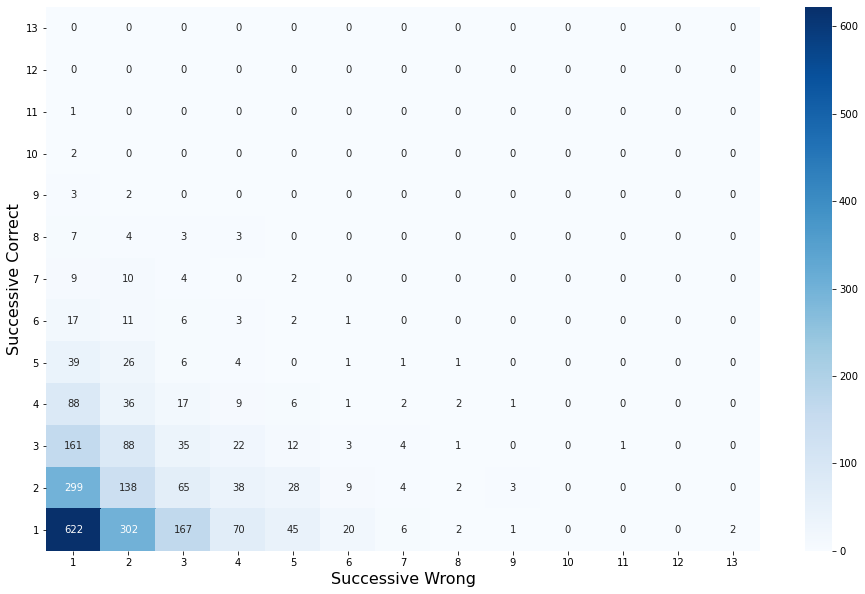

In [33]:
ti.plot_suc_fail()

In [31]:
# 失效的衡量：单点不算，而是去度量一个时间窗内的数据，比如说一个时间窗里的收益率、回撤、精确率准确率召回率、最大连续错误、交叉熵、
class test_indicator():
    def __init__(self, y_true, y_pred):
        assert len(y_pred) == len(y_true), f'Length of y is {len(y_pred)} while y_pred {len(y_true)}'
        self.y_pred = y_pred
        self.y_true = y_true
        self.suc_fail, fail_suc = np.array(self.successive_distribution())
        # 算这个比例是否要加权？
        self.successive_n_failure_rate = None
        self.period_entropy = None
        self.period_drawback = None
        self.volatility = None

    def successive_distribution(self):
        y_output = self.y_pred
        y = self.y_true
        continues_suc = 0
        continues_fail = 0
        result = []
        maxx = 0
        for i in range(0,len(y_output)):
            if y_output[i] == y[i]:
                continues_suc+=1
                if continues_fail!=0:
                    result.append(-continues_fail)
                    if continues_fail > maxx:
                        maxx = continues_fail
                    continues_fail = 0
            else:
                continues_fail+=1
                if continues_suc != 0:
                    result.append(continues_suc)
                    if continues_suc > maxx:
                        maxx = continues_suc
                    continues_suc = 0

        length = maxx+1
        suc_result = [[0] * length for i in range(length)]
        fail_result = [[0]*length for i in range(length)]

        for i in range(len(result)-1):
            if result[i]>0:
                suc_result[result[i]][-result[i+1]]+=1
            else:
                fail_result[-result[i]][result[i+1]]+=1
        return suc_result, fail_result

    def plot_suc_fail(self):
        plt.figure(figsize=(16,10))
        suc_result = pd.DataFrame(self.suc_fail).sort_index(ascending=False)
        sns.heatmap(suc_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
        plt.yticks(rotation=0)
        ax = plt.gca()
        plt.xlabel('Successive Wrong',fontsize=16)
        plt.ylabel('Successive Correct',fontsize=16)
        plt.show()
        plt.close()

    def plot_fail_suc(self):
        plt.figure(figsize=(16,10))
        fail_result = pd.DataFrame(self.suc_fail).sort_index(ascending=False)
        sns.heatmap(fail_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
        plt.yticks(rotation=0)
        ax = plt.gca()
        plt.xlabel('Successive Wrong',fontsize=16)
        plt.ylabel('Successive Correct',fontsize=16)
        plt.show()
        plt.close()

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def get_precision(self):
        return precision_score(self.y_true, self.y_pred)

    def get_recall(self):
        return recall_score(self.y_true, self.y_pred)

    def get_successive_n_failure_rate(self,n=5):
        if n > len(self.suc_fail):
            return 0
        return self.suc_fail[:,n:].sum() / self.suc_fail.sum()
    def get_entropy(self):
        # TODO: calculate entropy
        return 0
    def get_drawback(self):
        # TODO: calculate maximum drawback of this phrase.
        return 0
    def get_volatility(self):
        # 
        return 0

In [5]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain

# and we define our model here
def lstm_model(para_a=42, para_b=17):
    model = Sequential()
    model.add(LSTM(units=para_a, dropout=0.1, return_sequences=True, input_shape=(240,1),activation='tanh'))# (25,15)-57, (42,17)-58
    model.add(LSTM(units=para_b, dropout=0.08, activation='tanh'))
    # model.add(Dropout(0.08))# 加了之后同原先效果差不多，（应该一定程度上）可以防止过拟合
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Method 1, train for only one time (many many days, maybe 2000?) and test several times(let's try 250 days per test). 

In [6]:
train_begin = 240
train_end = train_begin + 10000
scaler = StandardScaler()
train_set = df[['log_r','label']][train_begin-240:train_end].reset_index()
x_train, y_train = [], []
x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
for i in range(240,len(x_train_set)):
    x_train.append(x_train_set[i-240:i])
    y_train.append(train_set['label'][i])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = to_categorical(y_train,2)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

# model = lstm_model()
# model.fit(x_train,y_train,epochs=30, batch_size=100, callbacks=[EarlyStopping(monitor='loss',patience=10)])

In [2]:
from bt_classes import *
def my_backtest(mydata, log=False, drawpic=False, iplot=False):
    plt.rcParams['figure.figsize'] = 12,8
    cerebro = bt.Cerebro()
    data = MyPandasData(dataname=mydata)
    cerebro.adddata(data)
    if log:
        cerebro.addstrategy(GoldStrategy)
    else:
        cerebro.addstrategy(GoldStrategy_nolog)
    cerebro.addsizer(OptInvest)
    init_value= 100000.0
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0,automargin=0.01,mult=100)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='ar')
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    thestrats = cerebro.run()
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % final_value)
    if drawpic:
        cerebro.plot(iplot=iplot,volume=False)
    sharpe = thestrats[0].analyzers.sharpe.get_analysis()['sharperatio']
    dd = thestrats[0].analyzers.dd.get_analysis()['max']['drawdown']
    ar = thestrats[0].analyzers.returns.get_analysis()['rnorm100']
    rt = thestrats[0].analyzers.returns.get_analysis()['ravg']
    sqn = thestrats[0].analyzers.sqn.get_analysis()
    # print(thestrats[0].analyzers.sharpe.get_analysis())
    print('Sharpe: {:.2f}'.format(sharpe))
    print('Max drawdown: {:.2f}%'.format(dd))
    print('Annual rate: {:.2f}%'.format(ar))
    print('Num of trades: {}'.format(sqn['trades']))
    print(rt)
    print('Average return per trade: {:.2f}%'.format(rt*100/sqn['trades']))
    # print(thestrats[0].analyzers.sqn.get_analysis())
    return sharpe,dd,ar

In [8]:
from keras.models import load_model
model = load_model('more_lstm.h5')
train_begin = 240
train_end = train_begin + 10000
train_df = orig_df[train_begin:train_end]
train_df['label'] = model.predict_classes(x_train)
my_backtest(train_df,drawpic=True,iplot=False,log=False)

Starting Portfolio Value: 100000.00
Final Portfolio Value: 52885.16


<IPython.core.display.Javascript object>

Sharpe: 0.03
Max drawdown: 84.01%
Annual rate: -3.18%
Num of trades: 539
-0.00012817855448292087
Average return per trade: -0.00%


(0.02833997444973924, 84.01448694329665, -3.178489039800472)

In [10]:
y_output = train_df['label']
y = train_set['label'][train_begin:train_end]
y_output, y

(datetime
 2000-12-04    1
 2000-12-05    0
 2000-12-06    1
 2000-12-07    0
 2000-12-08    0
              ..
 2019-12-25    0
 2019-12-26    0
 2019-12-27    0
 2019-12-30    0
 2019-12-31    0
 Name: label, Length: 4970, dtype: int64, 240     0.0
 241     1.0
 242     0.0
 243     0.0
 244     0.0
        ... 
 5205    1.0
 5206    0.0
 5207    1.0
 5208    1.0
 5209    0.0
 Name: label, Length: 4970, dtype: float64)

In [15]:
y_output = train_df['label'].values
y = train_set['label'][train_begin:train_end].values
continues_suc = 0
continues_fail = 0
result = []
maxx = 0
for i in range(0,len(y_output)):
    if y_output[i] == y[i]:
        continues_suc+=1
        if continues_fail!=0:
            result.append(-continues_fail)
            if continues_fail > maxx:
                maxx = continues_fail
            continues_fail = 0
    else:
        continues_fail+=1
        if continues_suc != 0:
            result.append(continues_suc)
            if continues_suc > maxx:
                maxx = continues_suc
            continues_suc = 0

length = maxx+1
suc_result = [[0] * length for i in range(length)]
fail_result = [[0]*length for i in range(length)]

for i in range(len(result)-1):
    if result[i]>0:
        suc_result[result[i]][-result[i+1]]+=1
    else:
        fail_result[-result[i]][result[i+1]]+=1
print(suc_result)
print(fail_result)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 354, 178, 86, 39, 15, 6, 4, 2, 0, 1, 0, 0, 0], [0, 157, 92, 34, 14, 8, 4, 2, 1, 1, 0, 0, 0, 0], [0, 81, 38, 20, 11, 5, 3, 0, 0, 0, 0, 0, 0, 0], [0, 41, 19, 6, 9, 3, 0, 1, 0, 0, 0, 0, 0, 0], [0, 20, 12, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 4, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 354, 153, 81, 44, 16, 5, 5, 2, 0, 2, 0, 0, 1], [0, 189, 74, 47, 19, 15, 4, 1, 1, 0, 0, 0, 0, 0], [0, 71, 45, 15, 11, 5, 2, 3, 0, 0, 0, 0, 0, 0], [0, 42, 21, 9, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0], [0, 13, 13, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0,

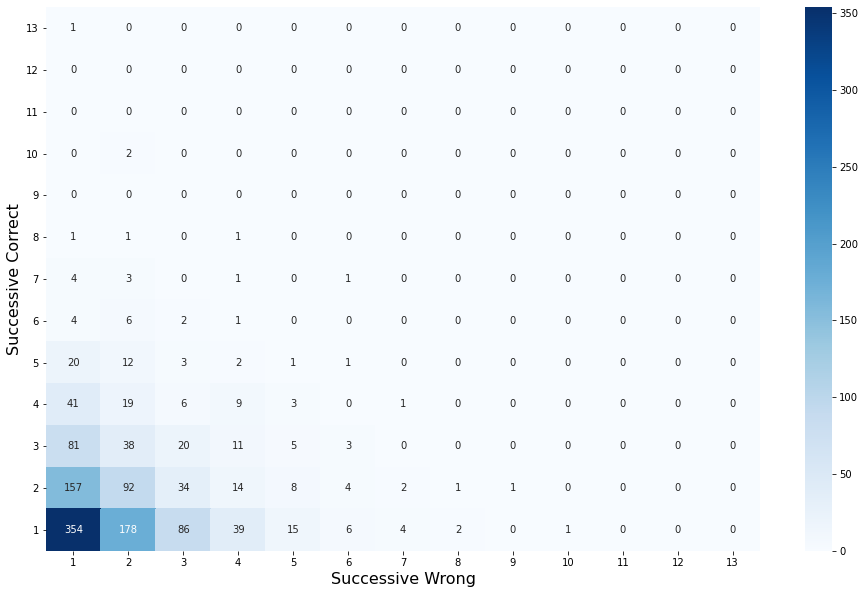

In [120]:
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(16,10))
suc_result = pd.DataFrame(suc_result).sort_index(ascending=False)
sns.heatmap(suc_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
plt.yticks(rotation=0)
ax = plt.gca()
plt.xlabel('Successive Wrong',fontsize=16)
plt.ylabel('Successive Correct',fontsize=16)
plt.show()

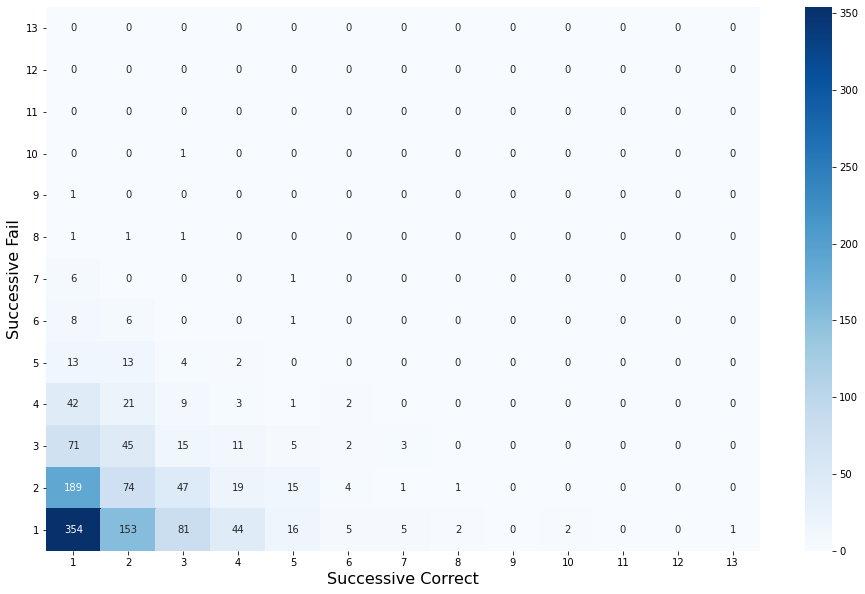

In [121]:
plt.figure(figsize=(16,10))
fail_result = pd.DataFrame(fail_result).sort_index(ascending=False)
sns.heatmap(fail_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Successive Correct',fontsize=16)
plt.ylabel('Successive Fail',fontsize=16)
plt.show()

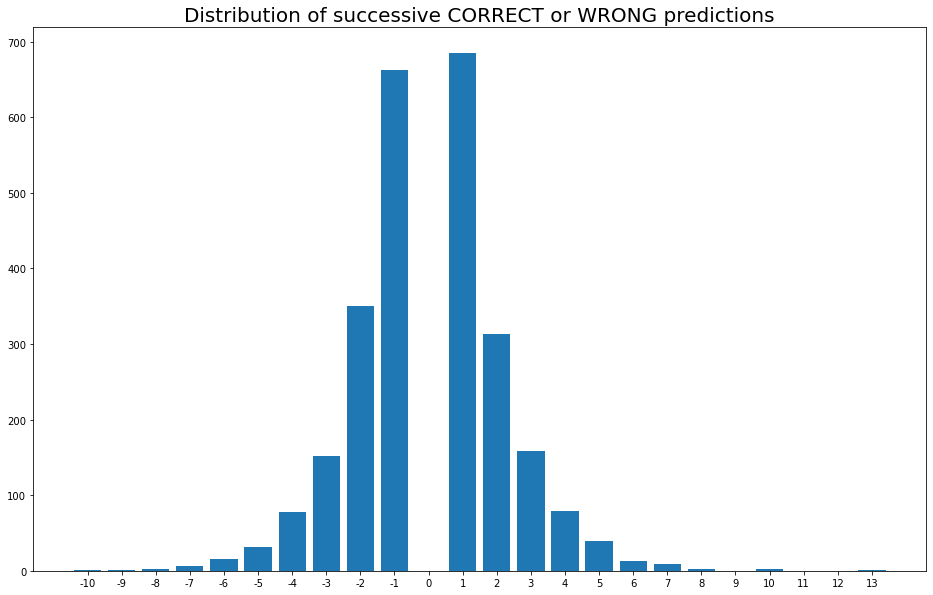

In [122]:
res = pd.DataFrame(result,columns=['successive']).reset_index().groupby('successive').count().reset_index()
plt.figure(figsize=(16,10))
plt.bar(res['successive'],res['index'],)
plt.xticks([x for x in range(np.min(result),np.max(result)+1)],list(range(np.min(result),np.max(result)+1)))
plt.title('Distribution of successive CORRECT or WRONG predictions',fontsize=20)
plt.show()

In [124]:
res['successive'].skew(),res['successive'].kurt()

(0.18400975803441041, -0.9946088335738192)

Starting Portfolio Value: 100000.00
Final Portfolio Value: 10725270135097.66


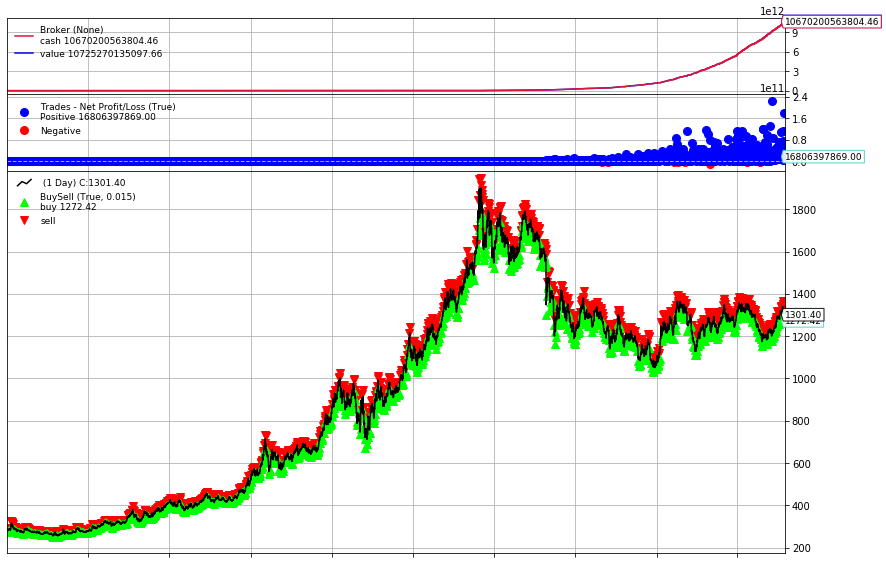

Sharpe: 7.53
Max drawdown: 1.02%
Annual rate: 153.94%
Num of trades: 2616
0.0036981396605753796
Average return per trade: 0.00%


(7.534696167070488, 1.0223403108400813, 153.94085369983247)

In [35]:
%matplotlib inline
my_backtest(df[:5000],drawpic=True,iplot=False,log=False)

In [ ]:
train_df['label'].describe()

In [ ]:
model.summary()

In [ ]:
model.save('more_lstm.h5')

In [ ]:
from tqdm import tqdm
from sa import *
from utils import *

# Please select the last activation layer.
layer_names = ['lstm_6']

default_upper_bound = 2000
default_n_bucket = 1000
default_n_classes = 2
class Args(): #创建一个类
    def __init__(self): #定义初始化信息。
        self.is_classification = True
        self.save_path = './tmp/'
        self.d = 'lstm_r'
        self.num_classes = 2
        self.lsa = True
        self.dsa = True
        self.target = 'none'
        self.batch_size = 128
        self.var_threshold = 1e-5
        self.upper_bound = 2000
        self.n_bucket = 1000
        self.is_classification = True
args = Args()

In [ ]:
starter = range(10240,len(df)-250,250)
all_results = []

for test_begin in starter:
    test_end = test_begin + 250

    x_test, y_test = [], []
    test_set = df[['log_r','label']][test_begin-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)

    test_dsa = fetch_dsa(model, x_train, x_test, 'dsa from{}'.format(test_begin), layer_names, args)
    dsa_cov = get_sc(np.amin(test_dsa), 5, 20, test_dsa)
    test_lsa = fetch_lsa(model, x_train, x_test, 'lsa from{}'.format(test_begin), layer_names, args)
    lsa_cov = get_sc(np.amin(test_lsa), 1500, 20, test_lsa)
    eva = model.evaluate(x_test, y_test)
    print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eva[0], eva[1]))
    print('Dsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa)))
    print('Lsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa)))
    test_df = orig_df[test_begin:test_end]
    test_df['label'] = model.predict_classes(x_test)
    sharpe,dd,ar = my_backtest(test_df)
    this_result = [test_begin,eva[0], eva[1],dsa_cov,np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa),lsa_cov,np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa),sharpe,dd,ar]
    all_results.append(this_result)

In [ ]:
cols = ['test_begin','loss', 'accu','dsa_cov','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_cov','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual_return']
result_df = pd.DataFrame(all_results,columns=cols)

In [ ]:
result_df.to_csv('rs.csv')